# Global ms diagnosis on main combination
- compute MSRe, nMSRe, $C_{\alpha}$, captured physical signal and error parts
- evaluate H1

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt

import histlib.matchup as match
from  histlib.diagnosis import global_ms_drifter_sat_year, compute_sum_ms, nMSRe_id, C_x, true_err_x, plot_true_err_cor_part, plot_cor_uncor_part
from histlib.cstes import labels, zarr_dir, matchup_dir, var, c0, c1
from histlib.matchup import _data_var, _stress_var, _aviso_var

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
DL =25*1e3 #meters
DT = 1800.0 #seconds
id_aviso = 'aviso__25__adt__es_cstrio_z15__alti_x'
id_co = 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x'

id_co_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wind':'es_cstrio_z15_alti_wd_x'}
id_aviso_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'aviso_alti_ggx_adt','wind':'es_cstrio_z15_alti_wd_x'}

# Datasets 

In [3]:
dsms = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'ms_{int(DL//1000)}_{DT}_drogued.zarr'))
gps = [l for l in dsms.drifter_sat_year.values if 'gps' in l]
dsmean = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'mean_{int(DL//1000)}_{DT}_drogued.zarr'))

ds, mslow, msup = global_ms_drifter_sat_year(dsmean.sel(drifter_sat_year=gps), dsms.sel(drifter_sat_year=gps), alpha=0.01)
mserr = (msup-mslow)/2

<xarray.DataArray 'nb_coloc' ()>
array(146030)


In [4]:
dsms.sel(drifter_sat_year='gps_Sentinel-3_A_2019')

<xarray.Dataset>
Dimensions:                                                                                   (
                                                                                               id_comb: 80)
Coordinates:
    drifter_sat_year                                                                          <U32 ...
  * id_comb                                                                                   (id_comb) <U75 ...
Data variables: (12/425)
    alti_ggx_adt_filtered                                                                     float64 ...
    alti_ggx_adt_filtered_ocean_tide                                                          float64 ...
    alti_ggx_adt_filtered_ocean_tide_internal_tide                                            float64 ...
    alti_ggx_adt_filtered_ocean_tide_internal_tide_dac                                        float64 ...
    aviso_alti_ggx_adt                                                                        float64 ...
    aviso_drifter_ggx_adt                                                                     float64 ...
    ...                                                                                        ...
    sum_co__2__adt_filtered_ocean_tide__es_cstrio_z15__alti_x                                 float64 ...
    sum_co__2__adt_filtered_ocean_tide__es_cstrio_z15__drifter_x                              float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x                   float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__drifter_x                float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide_dac__es_cstrio_z15__alti_x               float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide_dac__es_cstrio_z15__drifter_x            float64 ...

______________________
# Closure efficiancy : MSRe $\langle S^2 \rangle$ and $nMSRe = \frac{\langle S^2 \rangle}{\sum_i \langle x_i^2 \rangle}$
- AVISO more efficient

In [5]:
print('Along-track')
print('MSRe = ' + f"{ds['sum_'+id_co].values,mserr['sum_'+id_co].values }")
print(f"nMSRe = {nMSRe_id(ds,mserr, id_co)}")
print('AVISO')
print('ReMS = ' + f"{ds['sum_'+id_aviso].values, mserr['sum_'+id_aviso].values}")
print(f"nMSRe = {nMSRe_id(ds,mserr, id_aviso)}")

Along-track
MSRe = (array(1.55309182e-10), array(1.48050398e-12))
nMSRe = (array(19.3874156), array(0.36962588))
AVISO
ReMS = (array(1.39110801e-10), array(1.32609095e-12))
nMSRe = (array(20.58652679), array(0.39248724))


Text(0, 0.5, 'MSRE $[m^2/s^4]$')

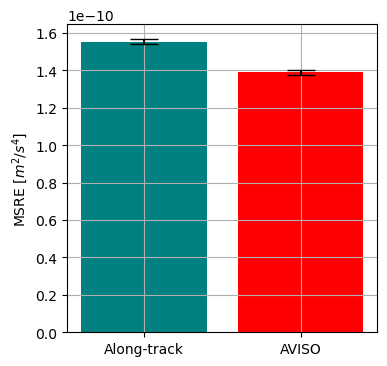

In [6]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

ax.bar(0.5, ds['sum_'+id_co], yerr =mserr['sum_'+id_co],  color ='teal',width = 0.4, capsize=10)
ax.bar(1, ds['sum_'+id_aviso], yerr =mserr['sum_'+id_aviso], color ='red',width = 0.4, capsize=10)

ax.grid()

ticks = ('Along-track', 'AVISO')
ax.set_xticks([0.5, 1], ticks,)
ax.set_ylabel(r'MSRE $[m^2/s^4]$')

Text(0, 0.5, '$nMSRe$ [%]')

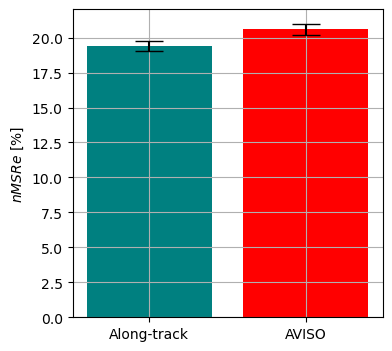

In [7]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

ax.bar(0.5, nMSRe_id(ds,mserr, id_co)[0],yerr = nMSRe_id(ds,mserr, id_co)[1], color ='teal',width = 0.4, capsize=10)
ax.bar(1, nMSRe_id(ds,mserr, id_aviso)[0], yerr = nMSRe_id(ds, mserr,id_aviso)[1], color ='red',width = 0.4, capsize=10)

ax.grid()

ticks = ('Along-track', 'AVISO')
ax.set_xticks([0.5, 1], ticks,)
ax.set_ylabel(r'$nMSRe$ [%]')

______________________
# $\alpha$ contribution : $C_{\alpha} =\langle S_{-\alpha_i}^2\rangle-\langle S^2 \rangle$ 

In [8]:
CX = C_x(ds,mserr, [id_co, id_aviso])

In [9]:
CX

,acc,coriolis,ggrad,wind,acc_err,coriolis_err,ggrad_err,wind_err
id_comb,,,,,,,,
co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x,6.612105e-11,2.420309e-10,1.708315e-10,1.148061e-11,3.591315e-12,5.268198e-12,4.589481e-12,3.070448e-12
aviso__25__adt__es_cstrio_z15__alti_x,2.389318e-11,1.746366e-10,1.870299e-10,1.195582e-11,2.879947e-12,4.316927e-12,4.435068e-12,2.766152e-12


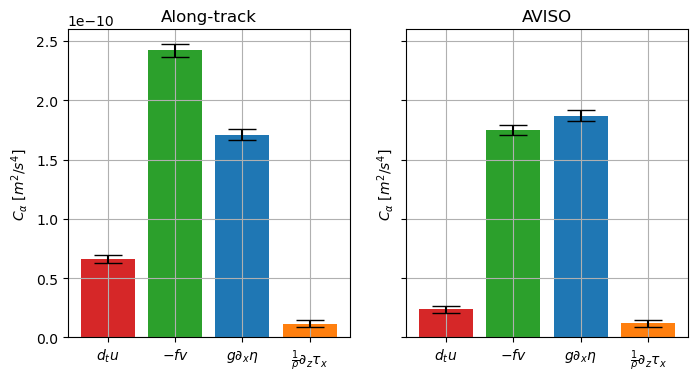

In [10]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(8,4), sharey=True)
ax=axs[0]
df = CX.loc[id_co]
ax.bar(0.5, df.acc, yerr=df.acc_err, color =c0['acc'],width = 0.4, capsize=10)
ax.bar(1, df.coriolis,yerr=df.coriolis_err, color =c0['coriolis'],width = 0.4, capsize=10)
ax.bar(1.5, df.ggrad,yerr=df.ggrad_err, color =c0['ggrad'],width = 0.4, capsize=10)
ax.bar(2, df.wind,yerr=df.wind_err, color =c0['wind'],width = 0.4, capsize=10)
ax.set_title('Along-track')

ax=axs[1]
df = CX.loc[id_aviso]
ax.bar(0.5, df.acc,yerr=df.acc_err, color =c0['acc'],width = 0.4, capsize=10)
ax.bar(1, df.coriolis,yerr=df.coriolis_err, color =c0['coriolis'],width = 0.4, capsize=10)
ax.bar(1.5, df.ggrad,yerr=df.ggrad_err, color =c0['ggrad'],width = 0.4, capsize=10)
ax.bar(2, df.wind,yerr=df.wind_err, color =c0['wind'],width = 0.4, capsize=10)
ax.set_title('AVISO')

for ax in axs :
    ax.grid()
    ticks = (r'$d_tu$', r'$-fv$', r'$g \partial_x \eta$', r'$\frac{1}{\rho}\partial_z\tau_x$')
    ax.set_xticks([0.5, 1, 1.5, 2], ticks,)
    ax.set_ylabel(r'$C_{\alpha}$ $[m^2/s^4]$')
    

_____________
# Correlation + explained/error parts

$\langle \hat{\alpha_i} \rangle +\langle \hat{\alpha_i}{\alpha_i^{e}}^2 \rangle  = \frac{1}{2}(\langle \alpha_i^2 \rangle - \langle S^2 \rangle +\langle S_{-\alpha_i}^2 \rangle) $  

$\langle {\alpha_i^{e}}^2 \rangle+\langle \hat{\alpha_i}{\alpha_i^{e}}^2 \rangle  = \frac{1}{2}(\langle \alpha_i^2 \rangle + \langle S^2 \rangle -\langle S_{-\alpha_i}^2 \rangle) $
## Under H1

$\langle \hat{\alpha_i} \rangle  = \frac{1}{2}(\langle \alpha_i^2 \rangle - \langle S^2 \rangle +\langle S_{-\alpha_i}^2 \rangle) $  

$\langle {\alpha_i^{e}}^2 \rangle  = \frac{1}{2}(\langle \alpha_i^2 \rangle + \langle S^2 \rangle -\langle S_{-\alpha_i}^2 \rangle) $


In [11]:
def global_cor(dsc):
    #global ms
    cor = (((dsc*dsc.nb_coloc).sum('drifter_sat_year'))/(dsc.nb_coloc.sum('drifter_sat_year'))).drop('nb_coloc')
    print(dsc.nb_coloc.sum('drifter_sat_year'))
    for v in dsc.keys():
        if v != 'nb_coloc':
            cor[v].attrs=dsc[v].attrs
    
    #nb_coloc
    nb_coloc = dsc.nb_coloc.sum('drifter_sat_year')
    cor['nb_coloc']=nb_coloc
    return cor

In [12]:
import itertools
corr_key_co = list(itertools.combinations(list(id_co_dic.values()),2))
corr_key_av = list(itertools.combinations(list(id_aviso_dic.values()),2)) 
corr_var_co = ["prod_"+ab[0]+"__"+ab[1] for ab in corr_key_co]
corr_var_aviso = ["prod_"+ab[0]+"__"+ab[1] for ab in corr_key_av]

dsc = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'corr_{int(DL//1000)}_{DT}_drogued.zarr'))[corr_var_co+['nb_coloc']]
gps = [l for l in dsc.drifter_sat_year.values if 'gps' in l]
dscor_co = global_cor(dsc.sel(drifter_sat_year=gps))

dsc = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'corr_{int(DL//1000)}_{DT}_drogued.zarr'))[corr_var_aviso+['nb_coloc']]
gps = [l for l in dsc.drifter_sat_year.values if 'gps' in l]
dscor_aviso = global_cor(dsc.sel(drifter_sat_year=gps))

<xarray.DataArray 'nb_coloc' ()>
array(146030)
<xarray.DataArray 'nb_coloc' ()>
array(146030)


In [62]:
dsms = xr.concat([true_err_x(ds,mserr, id_co), true_err_x(ds,mserr, id_aviso)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(75.09722222222221, 0.5, '[m^2/s^4]')

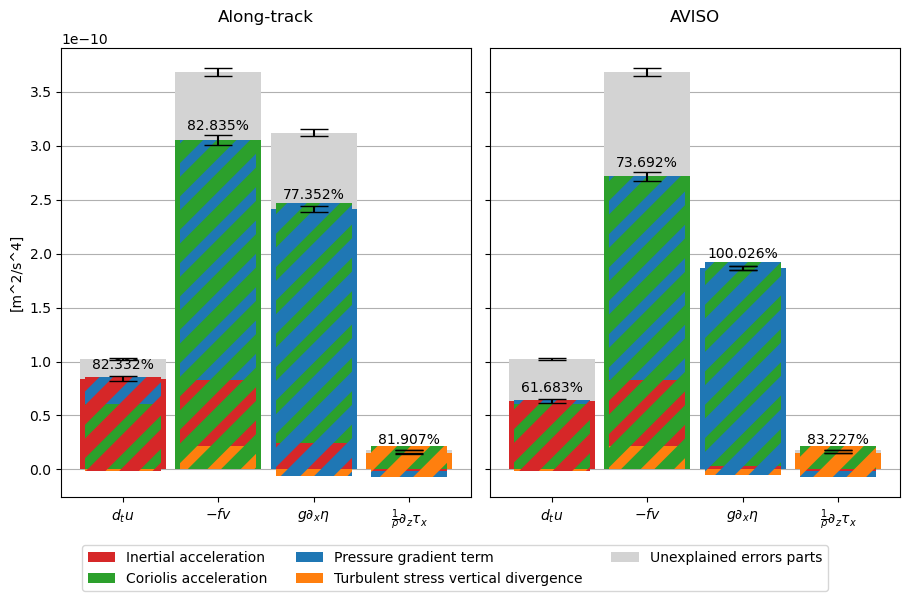

In [63]:
fig, ax = plt.subplots(1,2,figsize=(9,6), sharey=True)
plot_true_err_cor_part(dsms.sel(id_comb=id_co), dscor_co, id_co_dic, ax[0], title='Along-track', rd=3)
plot_true_err_cor_part(dsms.sel(id_comb=id_aviso), dscor_aviso, id_aviso_dic, ax[1], title='AVISO', legend=False, rd=3)
fig.legend(ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.08,1,1])#left, bottom, right, top (default is 0,0,1,1)
ax[0].set_ylabel(r'[m^2/s^4]')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(75.09722222222221, 0.5, '[m^2/s^4]')

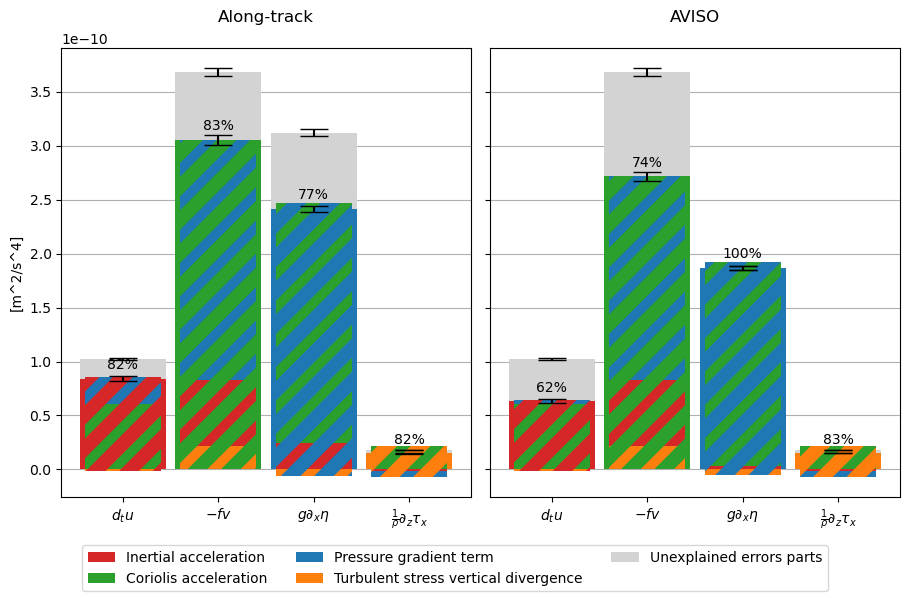

In [66]:
fig, ax = plt.subplots(1,2,figsize=(9,6), sharey=True)
plot_true_err_cor_part(dsms.sel(id_comb=id_co), dscor_co, id_co_dic, ax[0], title='Along-track')
plot_true_err_cor_part(dsms.sel(id_comb=id_aviso), dscor_aviso, id_aviso_dic, ax[1], title='AVISO', legend=False)
fig.legend(ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.08,1,1])#left, bottom, right, top (default is 0,0,1,1)
ax[0].set_ylabel(r'[m^2/s^4]')

(-1e-12, 3.8e-10)

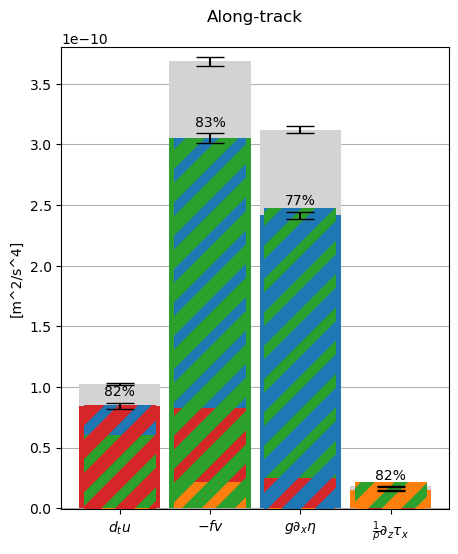

In [67]:
fig, ax = plt.subplots(1,1,figsize=(5,6), sharey=True)
plot_true_err_cor_part(dsms.sel(id_comb=id_co), dscor_co, id_co_dic, ax, title='Along-track')
#fig.legend(ncol=2,loc='lower center')#, bbox_to_anchoecompr=(1,         0.5))#bbox_transform=fig.transFigure,
#fig.tight_layout(rect=[0,0.1,1,1])#left, bottom, right, top (default is 0,0,1,1)
ax.set_ylabel(r'[m^2/s^4]')
ax.set_ylim(-1e-12,3.8e-10)

(-1e-12, 3.8e-10)

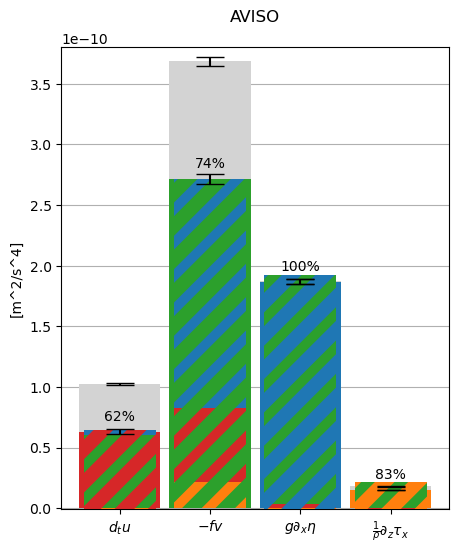

In [68]:
fig, ax = plt.subplots(1,1,figsize=(5,6), sharey=True)
plot_true_err_cor_part(dsms.sel(id_comb=id_aviso), dscor_aviso, id_aviso_dic, ax, title='AVISO')
#fig.legend(ncol=1,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
#fig.tight_layout(rect=[0,0.18,1,1])#left, bottom, right, top (default is 0,0,1,1)
ax.set_ylabel(r'[m^2/s^4]')
ax.set_ylim(-1e-12,3.8e-10)

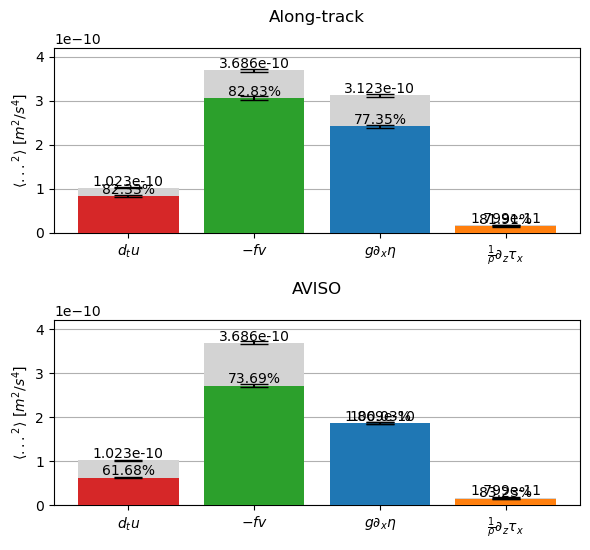

In [69]:
fig_title=1
fig, axs = plt.subplots(nrows=2,ncols=1,
                            sharey='all',
                            figsize=(6,7))
plot_cor_uncor_part(dsms.sel(id_comb=id_co), ax=axs[0], title ='Along-track')
plot_cor_uncor_part(dsms.sel(id_comb=id_aviso), ax=axs[1], title ='AVISO')
axs[0].set_ylim(0,4.2e-10)
axs[0].set_ylabel(r'$\langle ...^2 \rangle$ $[m^2/s^4]$')
axs[1].set_ylabel(r'$\langle ...^2 \rangle$ $[m^2/s^4]$')
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

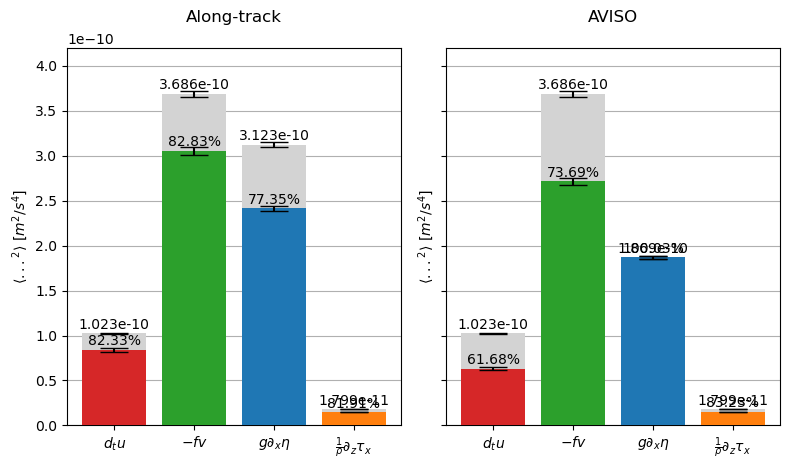

In [70]:
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=2,
                            sharey='all',
                            figsize=(8,6))
plot_cor_uncor_part(dsms.sel(id_comb=id_co), ax=axs[0], title ='Along-track')
plot_cor_uncor_part(dsms.sel(id_comb=id_aviso), ax=axs[1], title ='AVISO')
axs[0].set_ylim(0,4.2e-10)
axs[0].set_ylabel(r'$\langle ...^2 \rangle$ $[m^2/s^4]$')
axs[1].set_ylabel(r'$\langle ...^2 \rangle$ $[m^2/s^4]$')
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

_________
_________
# Synthetic figure

In [71]:
dscor_co

<xarray.Dataset>
Dimensions:                                                                       ()
Data variables:
    prod_drifter_acc_x_25__drifter_coriolis_x_25                                  float64 ...
    prod_drifter_acc_x_25__alti_ggx_adt_filtered_ocean_tide_internal_tide         float64 ...
    prod_drifter_acc_x_25__es_cstrio_z15_alti_wd_x                                float64 ...
    prod_drifter_coriolis_x_25__alti_ggx_adt_filtered_ocean_tide_internal_tide    float64 ...
    prod_drifter_coriolis_x_25__es_cstrio_z15_alti_wd_x                           float64 ...
    prod_alti_ggx_adt_filtered_ocean_tide_internal_tide__es_cstrio_z15_alti_wd_x  float64 ...
    nb_coloc                                                                      int64 ...

In [210]:
def synthetic_figure(ds, dsc, dic, ax) :
    plt.rcParams["axes.edgecolor"] = "w"
    a=1.5
    b = 2e-12
    bbox = dict(facecolor='w', alpha=0.8, edgecolor='w')
    def vn(id_dic, key1, key2):
        return 'prod_'+id_dic[key1]+'__'+id_dic[key2]
            
    ## INDIVIDUAL MS ##
    ax.barh(2*a, ds['acc'], color= c0['acc'], label = 'Inertial acceleration')
    ax.barh(2*a, ds['coriolis'], left =ds['acc']+b , color= c0['coriolis'], label = 'Coriolis acceleration')
    ax.barh(2*a, ds['ggrad'], left =ds['acc']+ds['coriolis']+2*b , color= c0['ggrad'], label = 'Pressure gradient term')
    ax.barh(2*a, ds['wind'], left =ds['acc']+ds['coriolis']+ds['ggrad']+3*b, color= c0['wind'], label = 'Vertical turbulent stress divergence')
    
    ts = ds['acc']+ds['coriolis']+ds['ggrad']+ds['wind']
    ax.text(ts/2, 2*a+0.5, r'Individual MS - Total initial MS $\langle \alpha^2 \rangle$', ha='center') 
    #percentage + MS
    key = ['acc', 'coriolis', 'ggrad', 'wind']
    for i in range(len(key)) :
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b, 2*a, f'{int(np.rint((ds[key[i]]/ts).values*100))}%', ha='center',bbox=bbox )
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b, 2*a-0.55, f'{np.format_float_scientific(ds[key[i]].values,precision = 1)}', ha='center')
    
    
    ## CAPTURED PHYSICAL + ERRORS PARTS ##
    ax.barh(1*a, ds['true_acc'], color= c0['acc'])
    ax.barh(1*a, ds['err_acc'], left = ds['true_acc'], color= 'lightgrey', label='Errors')
    ax.barh(1*a, ds['true_coriolis'], left =ds['true_acc']+ds['err_acc']+b, color= c0['coriolis'])
    ax.barh(1*a, ds['err_coriolis'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis'], color= 'lightgrey')
    ax.barh(1*a, ds['true_ggrad'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+b, color= c0['ggrad'])
    if ds['err_ggrad']>0 : 
        ax.barh(1*a, ds['err_ggrad'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad'], color= 'lightgrey')
        ax.barh(1*a, ds['true_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+ds['err_ggrad']+b, color= c0['wind'])
        ax.barh(1*a, ds['err_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+ds['err_ggrad']+ds['true_wind'], color= 'lightgrey')
    else : 
        print('ok')
        ax.barh(1*a, ds['true_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+2*b, color= c0['wind'])
        ax.barh(1*a, ds['err_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+ds['true_wind']+2*b, color= 'lightgrey')
    
    ax.text(ts/2, 1*a+0.5, r'Captured physical and errors parts MS $\langle \hat{\alpha}^2 \rangle$ and $\langle \alpha_e^2 \rangle$', ha='center') 
    #percentage + MS
    key = ['true_acc','err_acc', 'true_coriolis','err_coriolis', 'true_ggrad','err_ggrad', 'true_wind', 'err_wind']
    for i in range(len(key)) :
        d=0
        dx=0
        if i==len(key)-1 : 
            d=-0.1*a 
            dx = 3e-11
        if i==len(key)-2 : d=0.1*a 
        if 'aviso' in dic['ggrad'] and i==len(key)-3 : d=-0.1*a
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b/2, a+d, f'{int(np.rint((ds[key[i]]/ts).values*100))}%', ha='center', bbox=bbox)
        d=0        
        if i%2 ==1 : d=-0.1*a
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b/2+dx, a+d -0.55, f'{np.format_float_scientific(ds[key[i]].values,precision = 1)}', ha='center')
        
    ## PAIRS + RESIDUAL ##
    plt.rcParams['hatch.linewidth'] = 10
    plt.rcParams['hatch.color'] = c0['ggrad']
    ax.barh(0, dsc[vn(dic, 'coriolis', 'ggrad')], color=c0['coriolis'], hatch='/')
    plt.rcParams['hatch.color'] = c0['coriolis']
    ax.barh(0, dsc[vn(dic, 'acc', 'coriolis')], color=c0['acc'], hatch='/', left = dsc[vn(dic, 'coriolis', 'ggrad')]+b)
    plt.rcParams['hatch.color'] = c0['acc']
    ax.barh(0, dsc[vn(dic, 'acc', 'ggrad')], color=c0['ggrad'], hatch='/', left = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+2*b)
    plt.rcParams['hatch.color'] = c0['wind']
    ax.barh(0, dsc[vn(dic, 'coriolis', 'wind')], color=c0['coriolis'], hatch='/', left = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+3*b)
    ax.barh(0, ds['S'], color='lightgrey', left = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+dsc[vn(dic, 'coriolis', 'wind')]+4*b)

    tts = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+dsc[vn(dic, 'coriolis', 'wind')]+4*b+ds['S']

    sum_pairs = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+dsc[vn(dic, 'coriolis', 'wind')]+3*b
    ax.text(sum_pairs/2, 0.6, r"Pairs' contributions $C_{ij}$", ha='center')
    #accolade
    c = 1e-12
    id1 =0
    id2 = sum_pairs
    bx = [id1, id1, id2, id2]
    by = [0.45, 0.5, 0.5, 0.45]
    ax.plot(bx, by, 'k-', lw=2)
    ax.text(sum_pairs + ds['S']/2, 0.5, r'MSRe $\langle S^2 \rangle$', ha='center')

    #percentage + MS
    key = [vn(dic, 'coriolis', 'ggrad'),vn(dic, 'acc', 'coriolis'), vn(dic, 'acc', 'ggrad'), vn(dic, 'coriolis', 'wind')]
    for i in range(len(key)) :
        ax.text(sum([dsc[v] for v in key[:i]])+dsc[key[i]]/2+i*b, 0, f'{int(np.rint((dsc[key[i]]/ts).values*100))}%', ha='center', bbox=bbox)
        d=0
        if 'aviso' in dic['ggrad'] and key[i]== vn(dic, 'acc', 'ggrad') : d = -0.1*a
        ax.text(sum([dsc[v] for v in key[:i]])+dsc[key[i]]/2+i*b, 0-0.55+d, f'{np.format_float_scientific(dsc[key[i]].values,precision = 1)}', ha='center')
    
    ax.text(sum([dsc[v] for v in key])+ds['S']/2+i*b, 0, f'{int(np.rint((ds["S"]/ts).values*100))}%', ha='center', bbox=bbox)
    ax.text(sum([dsc[v] for v in key])+ds['S']/2+i*b, 0-0.55, f'{np.format_float_scientific(ds["S"].values,precision = 1)}', ha='center')

    # FIGURE SET
    ax.set_yticks([])
    ax.set_xlim(-1e-11, tts+1e-11)
    ax.set_ylim(-1, 4)
    ax.get_yaxis().set_visible(False)
    ax.annotate('',xy=(tts,-1),xytext=(0,-1),arrowprops={'arrowstyle':'->', 'facecolor':'k'})
    ax.set_xlabel(r'[$m^2/s^4$]')

Text(0.5, 0.98, 'Along-track')

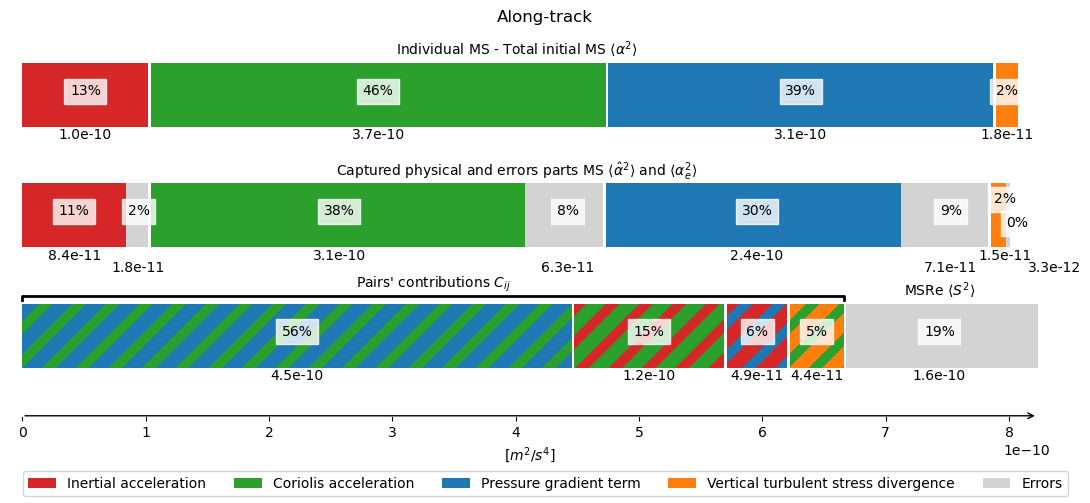

In [211]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(11,5), frameon=False)
synthetic_figure(dsms.sel(id_comb=id_co), -2*dscor_co, id_co_dic, ax) 
fig.legend(ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.04,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.suptitle('Along-track')

ok


Text(0.5, 0.98, 'AVISO')

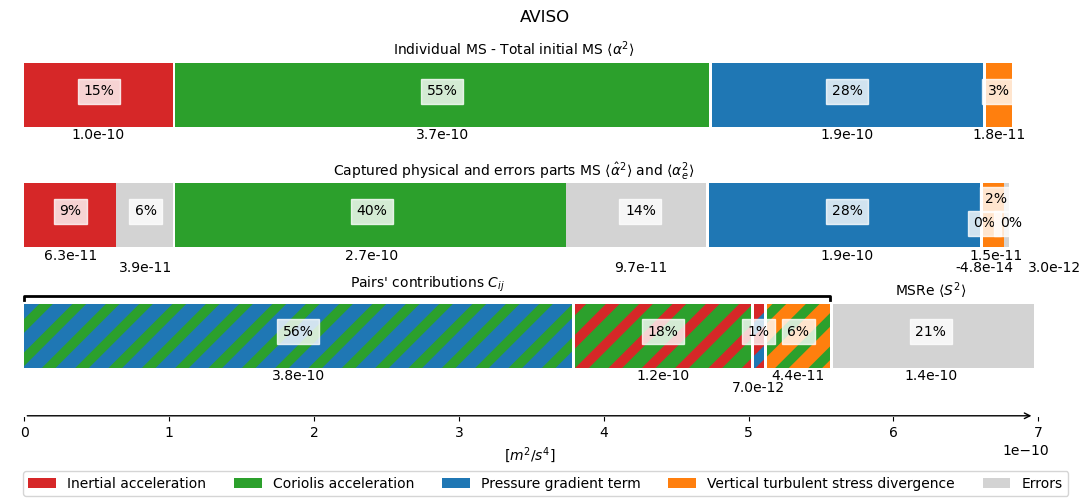

In [212]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(11,5), frameon=False)
synthetic_figure(dsms.sel(id_comb=id_aviso), -2*dscor_aviso, id_aviso_dic, ax) 
fig.legend(ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.04,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.suptitle('AVISO')

__________
_______
## Validité erreurs non corrélées :

- erreurs coriolis/acceleration doivent être correlées -> possible de le voir ?


$$ \langle S^2 \rangle - \sum_i A_{x_i} = \sum_x \langle \hat{x}x_e \rangle + \sum_i\sum_{j\neq i}[\langle {x_e}_i{x_e}_j \rangle + 2\langle {x_e}_i\hat{x}_j \rangle + \langle \hat{x}_i{x_e}_j \rangle] $$

In [24]:
dsmm = dsms*1e10

In [25]:
A = dsmm['err_acc']+dsmm['err_ggrad']+dsmm['err_wind']+dsmm['err_coriolis']

In [26]:
((A-dsmm['S'])/dsmm['S'])

<xarray.DataArray (id_comb: 2)>
array([-2.8593880e-16, -3.1923417e-16])
Coordinates:
  * id_comb  (id_comb) object 'co__25__adt_filtered_ocean_tide_internal_tide_...

In [27]:
dsmm['S']

<xarray.DataArray 'S' (id_comb: 2)>
array([1.55309182, 1.39110801])
Coordinates:
  * id_comb  (id_comb) object 'co__25__adt_filtered_ocean_tide_internal_tide_...

## Variance vs MS :

$$ Var(x) = MS(x) - mean(x)^2$$

but here $ mean(x)^2/MS(x) < 2.10^{-4} $ donc approximation  $Var(x)=MS(x)$ OK

In [28]:
def global_mean_drifter_sat_year(dsms):
    ds = (((dsms*dsms.nb_coloc).sum('drifter_sat_year'))/(dsms.nb_coloc.sum('drifter_sat_year'))).drop('nb_coloc')
    for v in dsms.keys():
        if v != 'nb_coloc':
            ds[v].attrs=dsms[v].attrs
    return ds

In [29]:
mean = global_mean_drifter_sat_year(dsmean.sel(drifter_sat_year=gps))

In [30]:
(mean/np.sqrt(ds))

<xarray.Dataset>
Dimensions:                                                                                   (
                                                                                               id_comb: 80)
Coordinates:
  * id_comb                                                                                   (id_comb) <U75 ...
Data variables: (12/424)
    alti_ggx_adt_filtered                                                                     float64 ...
    alti_ggx_adt_filtered_ocean_tide                                                          float64 ...
    alti_ggx_adt_filtered_ocean_tide_internal_tide                                            float64 ...
    alti_ggx_adt_filtered_ocean_tide_internal_tide_dac                                        float64 ...
    aviso_alti_ggx_adt                                                                        float64 ...
    aviso_drifter_ggx_adt                                                                     float64 ...
    ...                                                                                        ...
    sum_co__2__adt_filtered_ocean_tide__es_cstrio_z15__alti_x                                 float64 ...
    sum_co__2__adt_filtered_ocean_tide__es_cstrio_z15__drifter_x                              float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x                   float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__drifter_x                float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide_dac__es_cstrio_z15__alti_x               float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide_dac__es_cstrio_z15__drifter_x            float64 ...